# Import packages

In [76]:
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.linalg import orth
import time


from sca.dropout_models import SCA, WeightedPCA
# from sca.models import SCA, WeightedPCA
from sca.util import get_sample_weights, get_accuracy
import torch

In [77]:
# %load_ext autoreload
# %autoreload 2

# Simulate data
Data is simulated from sparsely occurring latents

In [78]:
#Function that creates a sine wave for a given amount of time (T),
#where the number of cycles (c) occurs during that time
def create_sine(T,c):
    tau=T/(2*np.pi)/c
    return np.sin(np.arange(0,T)/tau)

def Gaussian(sig=1, x_width=10):
    x_width = 10    # number of bins to evaluate Gaussian at 
    x = np.arange(-x_width//2, x_width//2)
    gaussian = np.exp(-(x/sig)**2/2)
    return gaussian

#### Generate the simulated data X0, which is size [Time x Num_neurons]

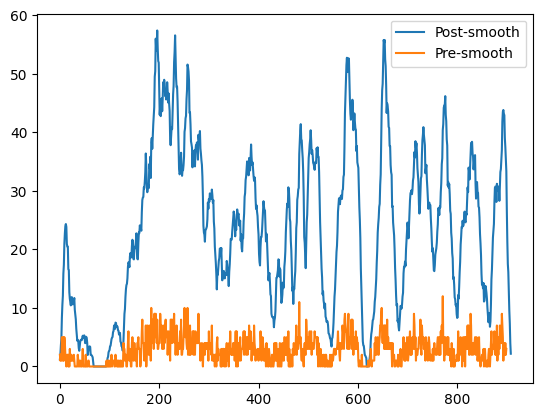

In [79]:
np.random.seed(0) #To get the same simulated data

# T=1200 #Time
# N_neurons=50 #Number of neurons
# R_sim=7 #Number of dimensions in lowD representations

# #Orthogonal matrix that projects low dimensional space to full neural space
# V_tmp=orth(npr.randn(R_sim,N_neurons).T).T 

# #Create low dimensional space
# Z=np.zeros([T,R_sim])
# for i in range(7):
#     Z[150*i:150*i+300,i]=create_sine(300,i+1)

# #Create high-dimensional neural activity    
# b=npr.randn(N_neurons) #Offset of neurons
# X0=Z@V_tmp[:R_sim,:]+b #Project into high-dimensional space and add offset
# X0=X0+.1*npr.randn(X0.shape[0],X0.shape[1]) #Add noise

T=900           # Time
N=50            # Number of neurons
# R_sim=5         # Number of latent dimensions
R_sim=5         # Number of latent dimensions
dts=0.01        # Firing rate will initially be in seconds -> this converts to spikes per 10 ms
avg_fr=300      # The desired average firing rate in spikes / second
std=5           # Stddev of Gaussian used to smooth spike counts - units are dts*seconds

#Create low dimensional space
Z=np.zeros([T,R_sim])
for i in range(R_sim):
    Z[150*i:150*i+300,i]=create_sine(300,i+1)

# Plot our created ground-truth latent dimensions
for dim in range(R_sim):
    plt.subplot(R_sim,1,dim+1)
    plt.plot(Z[:,dim])
    plt.ylabel(f"$z_{dim}$")
plt.clf()

# Orthogonal matrix that projects low dimensional space to full "neural" space (firing rates)
V_tmp=orth(npr.randn(R_sim,N).T).T

# Project latents up into firing-rate space (num_spikes per second)
X_fr = Z @ V_tmp

# We can't have negative firing rates
X_fr -= X_fr.min(axis=0)

# Scale firing rates s.t. we get desired average firing rate across all "neurons"
X_fr *= avg_fr/X_fr.mean()

# Convert firing rates to spike counts drawn from a Poisson
X_spikes = npr.poisson(X_fr * dts)

# Make Gaussian kernel for smoothing the spike counts
gaussian = Gaussian(sig=std)

# Smooth spike counts w.r.t. time
X_smoothed = []
for x in X_spikes.T:
    X_smoothed.append(np.convolve(x, gaussian, mode="full"))
X_smoothed = np.stack(X_smoothed).T

# Plot example neuron before and after smoothing
plt.plot(X_smoothed[:,0], label='Post-smooth')
plt.plot(X_spikes[:,0], label='Pre-smooth')
plt.legend()
# plt.show()
# plt.clf()

#### Plot simulated data

Text(0.5, 1.0, 'Example simulated "neurons" ')

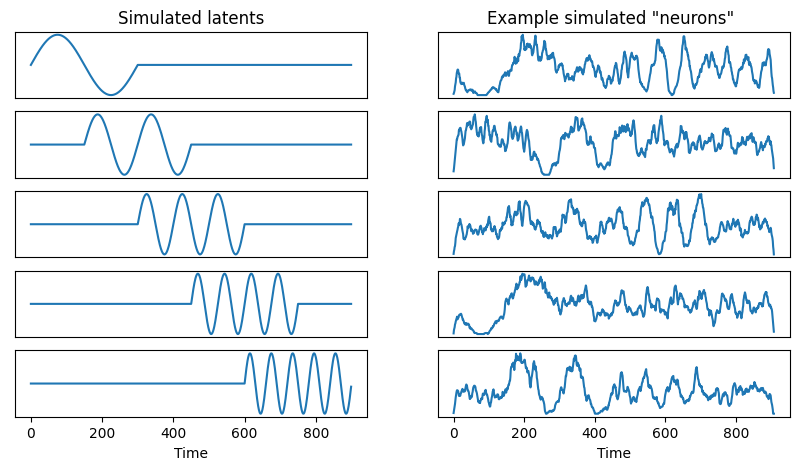

In [80]:
plt.figure(figsize=(10,5))
for i in range(R_sim):
    
    #Plot ground truth
    plt.subplot(R_sim,2,2*i+1)
    plt.plot((Z)[:,i]) 
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<R_sim-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
    
    # Plot Example neurons
    plt.subplot(R_sim,2,2*i+2)
    # plt.plot((X0)[:,i]) 
    plt.plot((X_smoothed)[:,i]) 
    
#     plt.ylim([-1.1, 1.1])
    plt.yticks([])    
    if i<R_sim-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

# Titles
plt.subplot(R_sim,2,1)
plt.title('Simulated latents')

plt.subplot(R_sim,2,2)
plt.title('Example simulated "neurons" ')


# Preprocess data (optional)

We have found that the method usually works better when zero-centering the data.

In this specific example, if you don't zero-center the data, it will take ~10000 iterations to converge to the ground truth, rather than ~2000.

In [81]:
# X = np.copy(X0)
# X = np.copy(X_smoothed)
X = np.copy(X_spikes)
# X=np.copy(X0-np.mean(X0,axis=0)[None,:])

# Set required model parameters

In [82]:
#Number of dimensions in the low-D model you're fitting
n_components=6

# Set some optional model parameters

All of these have default values, so it's not essential to set them. Below just shows most of the parameters you can set.

In [83]:
#Number of epochs of model fitting (default is 3000)
n_epochs=10000
# n_epochs=1400

#Learning rate of model fitting (default is .001)
lr=.01

#Whether to have a strict orthogonality constraint in the loadings (default is False)
#Note that the version of SCA that has orth=False runs faster
orth=False

#Initialization of weights - can be 'pca' or 'rand' (default is 'pca')
init='pca'

#We would recommend using the default lambda hyperparameters, at least to start. 
#When running SCA, it will print what the default values are for the given dataset

#Strength of the sparsity penalty
lam_sparse=.1

#Strength of the orthogonality penality (Note - This is only used in the version without a hard orthogonality constraint)
lam_orthog=1

In [84]:
#How much to weight each data point in time
#(this can be helpful for making sure dimensions still aim to explain time points with low activity)

sample_weights=np.ones([X.shape[0],1]) #Weight equally

# sample_weights=get_sample_weights(X) #Weight inversely to norm of activity at each time point

# Fit Weighted PCA Model (for comparison)

In [85]:
#Fit weighted PCA
#Note that this function does not automatically subtract the mean from the data (as in many PCA functions)

#Decleare model
wpca=WeightedPCA(n_components=n_components)

#Fit and get the low dimensional representation (the principal components)
#Note that the sample_weight input is optional and will default to no sample weighting
pca_latent = wpca.fit_transform(X,sample_weight=sample_weights)

# Fit SCA Model
We show options for running SCA below (with and without optional parameters).

In [86]:
#Declare SCA model without all the optional parameters
# sca=SCA(n_components=n_components)

#Declare SCA model with the optional parameters
# sca=SCA(n_components=n_components,orth=orth, lam_sparse=lam_sparse, lam_orthog=lam_orthog, lr=lr,n_epochs=n_epochs, init=init)

# TODO: add scalar * the lam values = the same value as the coordinated dropout rate
sca=SCA(poisson=True,n_components=n_components,orth=orth, lam_sparse=0.1, lam_orthog=150, lr=1e-3,n_epochs=35000, init=init)

#Fit the model and get the low dimensional representation
#Note that the sample_weight input is optional and will default to no sample weighting
sca_latent=sca.fit_transform(X=X, sample_weight=sample_weights)

Using device cpu


100%|██████████| 35000/35000 [04:32<00:00, 128.35it/s]

final sigmas:  Parameter containing:
tensor([1.0950, 2.1738, 1.9342, 2.1563, 2.4624, 1.9925], requires_grad=True)
final loss sigmas:  Parameter containing:
tensor([1., 1., 1., 1., 1., 1.], requires_grad=True)


Text(0, 0.5, 'Loss')

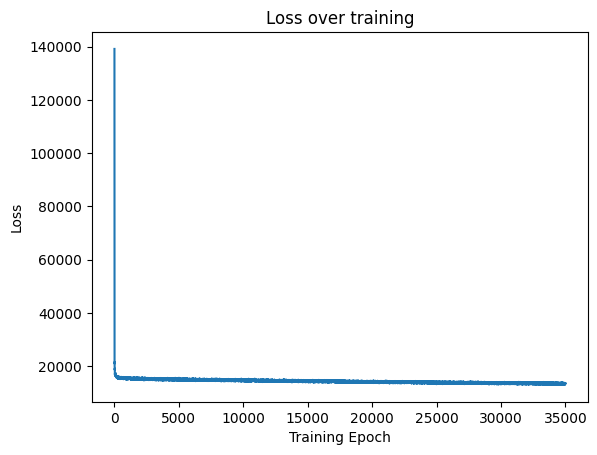

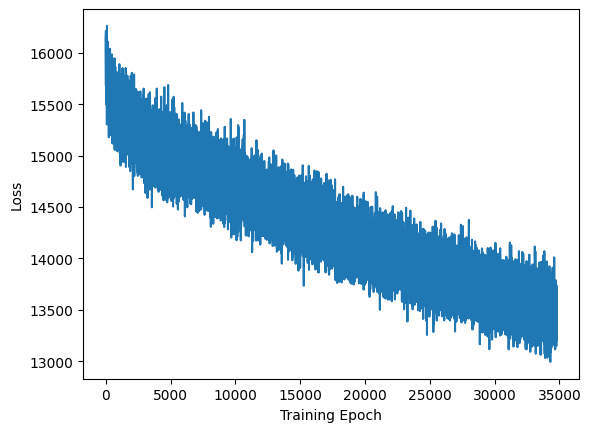

In [87]:
#Plot the loss over all iterations
plt.figure()
plt.plot(sca.losses)
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Loss over training')

#Plot the loss over the last 100 iterations (to see if it has truly hit a plateau)
# plt.figure()
# plt.plot(sca.losses[-200:-1])
# # plt.plot(sca.losses[4000:])
# plt.xlabel('Training Epoch')
# plt.ylabel('Loss')
# print("losses: ", sca.losses[0])

plt.figure()
# plt.plot(sca.losses[-100:-1])
plt.plot(sca.losses[200:])
plt.xlabel('Training Epoch')
plt.ylabel('Loss')

# plt.figure()
# plt.plot(sca.total_losses)
# plt.xlabel('Training Epoch')
# plt.ylabel('Loss')
# plt.title('total Loss over training')

In [88]:
print(np.argmax(sca.losses))

0


# Plot Latents

### Plot unordered lowD representations

### Order low-dimensional representations by time of maximum variance explained by that dimension.

In [89]:
#Amount of squared activity each dimension explains in PCA
infs_pca=[np.sum((pca_latent[:,i:i+1]@wpca.params['V'][i:i+1,:])**2,axis=1) for i in range(n_components)]

#Amount of squared activity each dimension explains in SCA
infs_sca=[np.sum((sca_latent[:,i:i+1]@sca.params['V'][:,i:i+1].T)**2,axis=1) for i in range(n_components)]

#Find the time point of each dimension that has the largest squared activity explained
max_array_pca=[np.argmax(infs_pca[i]) for i in range(n_components)]
max_array_sca=[np.argmax(infs_sca[i]) for i in range(n_components)]

#Order dimensions
pca_order=np.argsort(np.array(max_array_pca))
sca_order=np.argsort(np.array(max_array_sca))

#### Plot!

Text(0.5, 1.0, 'PCA LowD Projections')

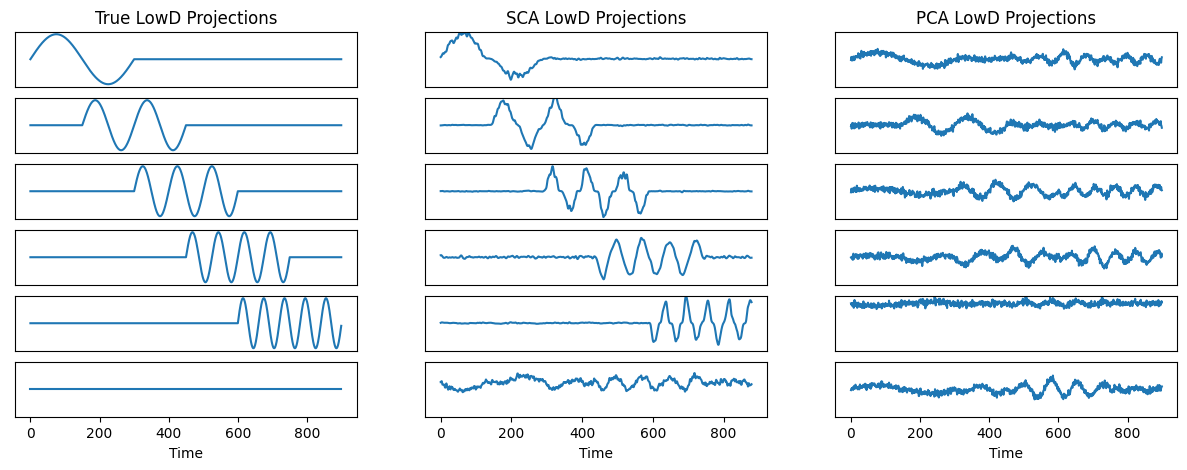

In [90]:
#Ground truth
Z_extra=np.zeros([T,n_components])
Z_extra[:,:R_sim]=Z


plt.figure(figsize=(15,5))
for i in range(n_components):
    
    #Plot ground truth
    plt.subplot(n_components,3,3*i+1)
    plt.plot((Z_extra)[:,i]) 
    
    plt.ylim([-1.1, 1.1])
    plt.yticks([])
    if i<n_components-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
    
    # Plot SCA results
    plt.subplot(n_components,3,3*i+2)
    plt.plot(sca_latent[:,sca_order[i]])
    
    plt.ylim([-11.1, 11.1])
    plt.yticks([])    
    if i<n_components-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

    # Plot PCA results
    plt.subplot(n_components,3,3*i+3)
    plt.plot(pca_latent[:,pca_order[i]])
    
    plt.ylim([-31.1, 31.1])
    plt.yticks([])
    if i<n_components-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')        

#Titles
plt.subplot(n_components,3,1)
plt.title('True LowD Projections')

plt.subplot(n_components,3,2)
plt.title('SCA LowD Projections')

plt.subplot(n_components,3,3)
plt.title('PCA LowD Projections')


In [91]:
print(sca.model.fc1.bias)
print(sca.model.fc0.bias)

Parameter containing:
tensor([ 0.3108,  0.0067, -0.0487,  0.0197, -0.0882,  0.0903],
       requires_grad=True)
Parameter containing:
tensor([ 0.0164,  0.1847,  0.0684,  0.1087, -0.0751,  0.0652,  0.3057,  0.0776,
         0.0495,  0.1609,  0.1426,  0.0477,  0.1607, -0.0439,  0.3486, -0.0769,
         0.0977,  0.2883,  0.0994, -0.0170,  0.0676,  0.0029, -0.1371,  0.1541,
         0.0867, -0.1046,  0.1052, -0.0080, -0.0961,  0.0248, -0.1379,  0.1719,
         0.0547,  0.0422,  0.0692,  0.1412,  0.0956,  0.1648,  0.2323,  0.0965,
         0.2011,  0.2525,  0.3462, -0.0435,  0.0801, -0.0131,  0.2040,  0.0372,
         0.0097, -0.0090], requires_grad=True)


## Look at how orthogonal the projection is
Show how orthogonal each of the latent dimensions are to each other

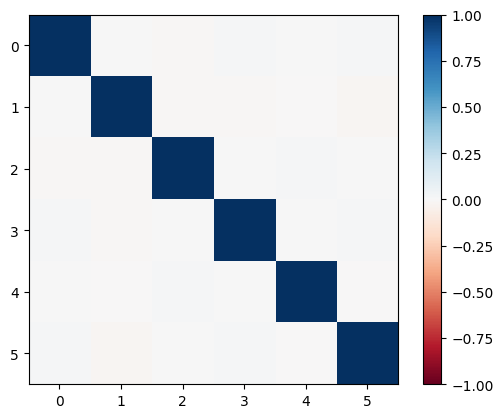

In [92]:
product=sca.params['V']@sca.params['V'].T
plt.imshow(product,clim=[-1,1],cmap='RdBu')
plt.colorbar()

## Get and plot reconstructed data

In [93]:
## Get reconstructed high-dimensionaldata
Xhat=sca.reconstruct(X)

ValueError: too many values to unpack (expected 2)

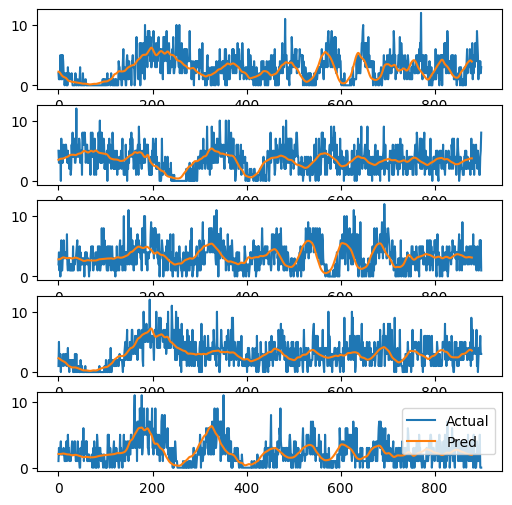

In [ ]:
## Plot example neurons

plot_neurons=[0,1,2,3,4] #example neurons to plot
n_plot_neurons=len(plot_neurons)

plt.figure(figsize=(6,6))
for i in range(n_plot_neurons):
    plt.subplot(n_plot_neurons,1,i+1)
    plt.plot(X[:,i])
    plt.plot(Xhat[:,i])
    
plt.legend(['Actual','Pred'],loc='right')

## Compare goodness of fit between SCA and PCA model (on the fit data)

Get: <br> 1) **Reconstruction loss** in the cost function (the weighted sum squared error) <br> 2) **R2 value** of the model (Neurons are weighted by their amount of variance, and sample-weighting is used)

In [ ]:
#For SCA, the reconstruction loss and r2 automatically get assigned to the model after fitting as attributes
print('SCA r2:', sca.r2_score)
print('SCA reconst_loss:', sca.reconstruction_loss)

SCA r2: 0.3544628421508358
SCA reconst_loss: 133144.9129138732


In [ ]:
#For PCA, we use the get_accuracy function from sca.utils
[pca_r2_score, pca_reconstruction_loss]=get_accuracy(wpca,X,sample_weights)

print('PCA r2:', pca_r2_score)
print('PCA reconstr_loss:', pca_reconstruction_loss)

PCA r2: 0.44724520881952773
PCA reconstr_loss: 115977.60321745698


## Some other attributes of SCA model

In [ ]:
#Squared neural activity that each latent explains (Note this is slightly different than variance because of the offset term)
sca.explained_squared_activity

array([1649.2794 ,  315.75986,  284.62592,  340.00842,  264.86914,
        330.5624 ], dtype=float32)

In [ ]:
#Hyperparameters of the model
print('n_components:',sca.n_components)
print('lam_sparse:',sca.lam_sparse)
print('lam_orthog:',sca.lam_orthog)

n_components: 6
lam_sparse: 0.2
lam_orthog: 150


In [ ]:
#parameters of the SCA model (commented out below)
#See Methods of manuscript for further details on the parameters

# sca.params['U']     #Matrix that projects high-d data to low-d space, size [N_neurons , n_components]
# sca.params['b_u']   #Offset for low-d space, size [n_components]
# sca.params['V']     #Matrix that projects low-d data to high-d space, size [n_components, N]
# sca.params['b_v']   #Offset for high-d space, size [N_neurons]